In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
    
from agents import *
from environments import RaceTrack
from IPython.display import Image

In [2]:
track = RaceTrack(RaceTrack.track_impossible)
track.set_eval()

selector = EpsilonGreedy(epsilon=0.0)
learner = NStepTreeBackup(n=5, alpha=0.5)
alpha_schedule = sigmoid_schedule(
    ["learner", "alpha"],
    learner.alpha,
    0.0,
)
epsilon_schedule = updown_schedule(
    ["selector", "epsilon"],
    selector.epsilon,
    0.1,
)

agent = Agent(
    num_states=track.num_states,
    num_actions=track.num_actions,
    selector=selector,
    learner=learner,
    schedules=[
        alpha_schedule,
        # epsilon_schedule,
    ],
)

trainer = Trainer(agent=agent, env=track)

In [3]:
trainer.train(
    num_episodes=100,
    early_stop=-1,
)

Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

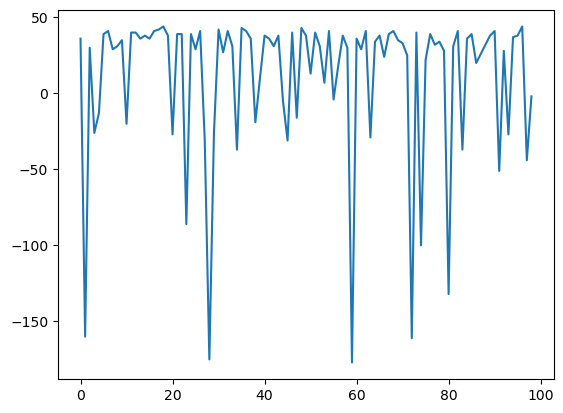

In [4]:
plt.plot(agent.ep_returns[1:])
plt.show()

Episode finished! Rendering animation...


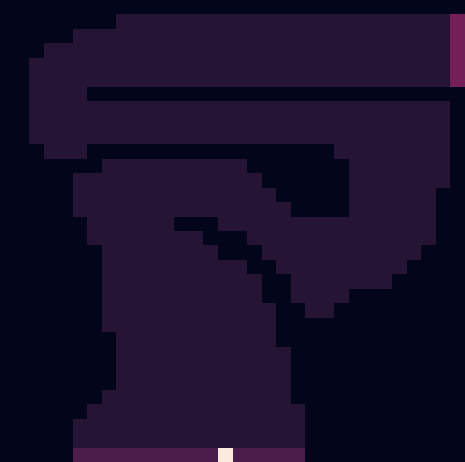

In [5]:
episode, _, _ = trainer.play_episode()
print("Episode finished! Rendering animation...")

ep_name = "testing"
filename = track.render_episode(episode, ep_name=ep_name)

Image(filename)

In [6]:
track = RaceTrack(RaceTrack.track_impossible)
track.set_eval()

selector = EpsilonGreedy(epsilon=0.0)
learner = NStepExpectedSarsa(n=5, alpha=0.5)
alpha_schedule = sigmoid_schedule(
    ["learner", "alpha"],
    learner.alpha,
    0.0,
)
epsilon_schedule = updown_schedule(
    ["selector", "epsilon"],
    selector.epsilon,
    0.1,
)

agent = Agent(
    num_states=track.num_states,
    num_actions=track.num_actions,
    selector=selector,
    learner=learner,
    schedules=[
        alpha_schedule,
        # epsilon_schedule,
    ],
)

trainer = Trainer(agent=agent, env=track)

In [7]:
trainer.train(
    num_episodes=100,
    early_stop=-1,
)

Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

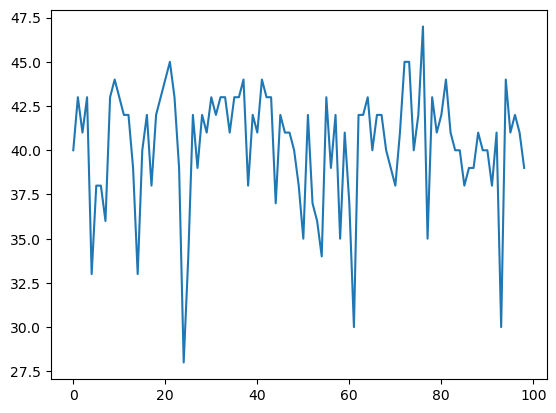

In [8]:
plt.plot(agent.ep_returns[1:])
plt.show()

Episode finished! Rendering animation...


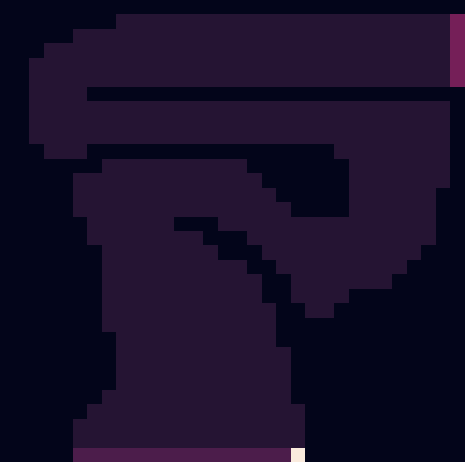

In [9]:
episode, _, _ = trainer.play_episode()
print("Episode finished! Rendering animation...")

ep_name = "testing"
filename = track.render_episode(episode, ep_name=ep_name)

Image(filename)